# Example notebook

In this notebook we show how to use the main methods of astroalign.
Full documentation available at https://astroalign.readthedocs.io/.

This notebook was created for astroalign version 2.1

*Martin Beroiz - September 2017. Updated September 2020.*

*Modified by Rainer Schödel - November 2023.* 


In [1]:
import astroalign as aa
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib inline

np.random.seed(seed=12)
aa.__version__

'2.4.1'


### Create images

We will create two images of the same portion of the sky. 

The target image will be (300, 300) pixels. It will have a Gaussian PSF with a sigma of ~3 pixels and Gaussian background noise.

Our source image will end up being (300, 300) pixels, will be rotated 30 degrees counter-clockwise with respect to the target image.  It will have a Gaussian PSF with a sigma of ~5 pixels and Gaussian background noise.

Notice that target image is made so to have better resolution (and seeing) than the source.


In [2]:
h, w = img_shape = (200, 200)
n_stars = 10
pos_x = np.random.randint(10, w - 10, n_stars)
pos_y = np.random.randint(10, h - 10, n_stars)
fluxes = 200.0 + np.random.rand(n_stars) * 300.0
img_posxy = np.array([[x, y] for x, y in zip(pos_x, pos_y)], dtype="float64")

img = np.zeros(img_shape)
for x, y, f in zip(pos_x, pos_y, fluxes):
    img[y, x] = f

# Let's rotate and expand the original image
from scipy.ndimage import rotate, zoom
img_rotated = rotate(img, angle=30.0, reshape=False)
img_rotated = zoom(img_rotated, 1.5, order=2)

# Let's add a Gaussian PSF response with different seeing for both images
from scipy.ndimage import gaussian_filter
img = gaussian_filter(img, sigma= 2.0, mode='constant')
img_rotated = gaussian_filter(img_rotated, sigma=1.5, mode='constant')

# Let's add some noise to the images
noise_dc = 5.0
noise_std = np.sqrt(noise_dc)
img += np.random.normal(loc=noise_dc, scale=noise_std, size=img.shape)
img_rotated += np.random.normal(loc=noise_dc, scale=noise_std, size=img_rotated.shape)

img_target = img_rotated
img_source = img
#write the images to file if you want to inspect them with ds9
fits.writeto('source.fits', img_target,overwrite=True)
fits.writeto('target.fits', img_source,overwrite=True)

### Solve registration with astroalign

**astroalign.register** will align the source image (first image passed to the function, here *img*) pixel by pixel with the target image (second image passed to the function, here *img_target*).

It will return the aligned image and the footprint of the transform.

`astroalign.register(source, target, fill_value=None, propagate_mask=False, max_control_points=50, detection_sigma=5, min_area=5)`

In [3]:
img_aligned, footprint = aa.register(img_source, img_target, detection_sigma=3.0)

# Try this too!! Solving using only lists of (x, y) positions
# t, __ = aa.find_transform(img_posxy, img_target)
# img_aligned, footprint = aa.apply_transform(t, img, img_target)

### Plot results

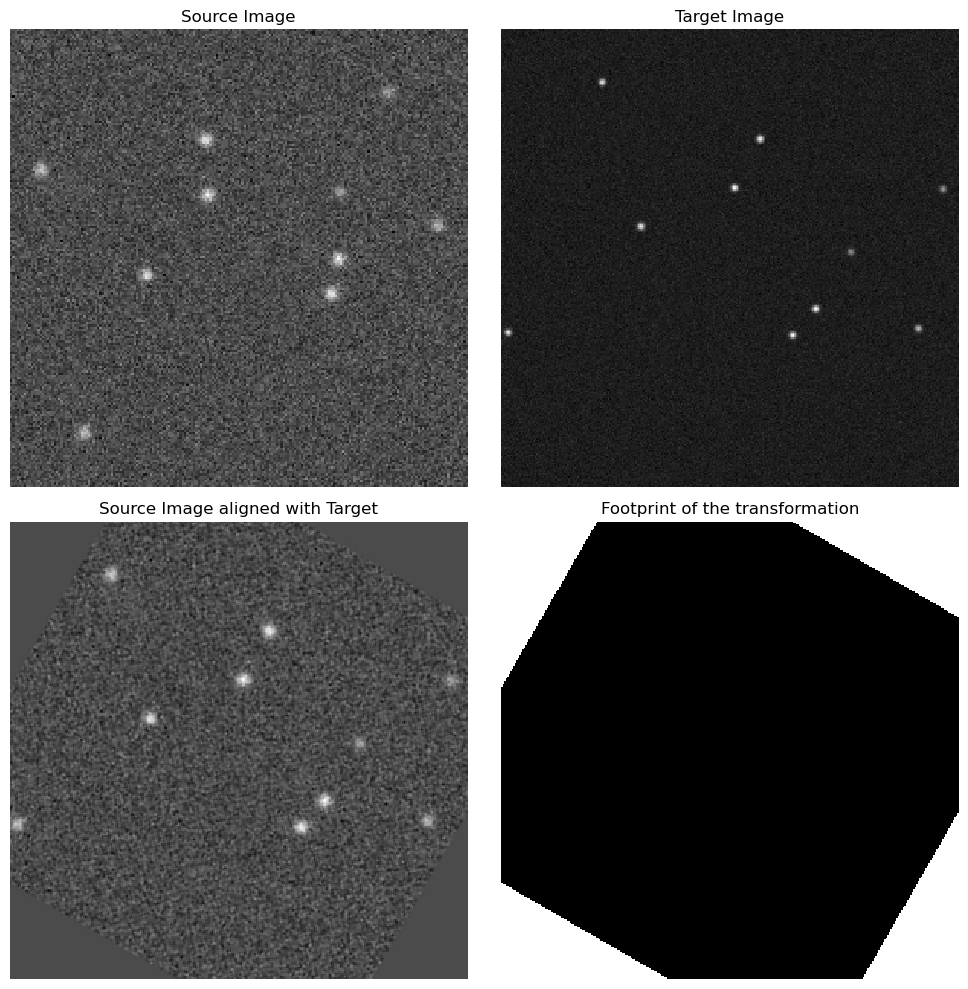

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(img_source, cmap='gray', interpolation='none', origin='lower')
axes[0, 0].axis('off')
axes[0, 0].set_title("Source Image")

axes[0, 1].imshow(img_target, cmap='gray', interpolation='none', origin='lower')
axes[0, 1].axis('off')
axes[0, 1].set_title("Target Image")

axes[1, 0].imshow(img_aligned, cmap='gray', interpolation='none', origin='lower')
axes[1, 0].axis('off')
axes[1, 0].set_title("Source Image aligned with Target")

axes[1, 1].imshow(footprint, cmap='gray', interpolation='none', origin='lower')
axes[1, 1].axis('off')
axes[1, 1].set_title("Footprint of the transformation")

axes[1, 0].axis('off')

plt.tight_layout()
plt.show()

### Inquiry the parameters of the transformation before applying

In some occasions we need to check for the parameters of the transformation before applying it. Or maybe we just need to know the parameters for further analysis.

Another situation is where we don't have the image arrays, but we have lists of the (x, y) positions of the stars.

In these cases, we can call **astroalign.find_transform**:

` astroalign.find_transform(source, target, max_control_points=50, detection_sigma=5, min_area=5)`

Note that in the example below we pass an array of data points and an image. In fact, you can pass images, arrays, or mixing both).

In [5]:
p, (pos_img, pos_img_target) = aa.find_transform(img_posxy, img_target)

### Parameters of the transformation

In [6]:
print("Rotation: {:.2f} degrees".format(p.rotation * 180.0 / np.pi))
print("\nScale factor: {:.2f}".format(p.scale))
print("\nTranslation: (x, y) = ({:.2f}, {:.2f})".format(*p.translation))
print("\nTranformation matrix:\n{}".format(p.params))
print("\nPoint correspondence:")
for (x1, y1), (x2, y2) in zip(pos_img, pos_img_target):
    print("({:.2f}, {:.2f}) is source --> ({:.2f}, {:.2f}) in target"
          .format(x1, y1, x2, y2))


Rotation: -29.99 degrees

Scale factor: 1.50

Translation: (x, y) = (-54.67, 94.79)

Tranformation matrix:
[[  1.30097821   0.75092708 -54.66721025]
 [ -0.75092708   1.30097821  94.79054671]
 [  0.           0.           1.        ]]

Point correspondence:
(140.00, 84.00) is source --> (190.53, 98.88) in target
(85.00, 151.00) is source --> (169.29, 227.37) in target
(165.00, 172.00) is source --> (289.14, 194.73) in target
(144.00, 128.00) is source --> (228.74, 153.25) in target
(13.00, 138.00) is source --> (65.94, 264.55) in target
(186.00, 114.00) is source --> (273.00, 103.32) in target
(86.00, 127.00) is source --> (152.53, 195.47) in target
(32.00, 23.00) is source --> (4.25, 100.65) in target
(59.00, 92.00) is source --> (91.24, 170.21) in target
(143.00, 99.00) is source --> (205.69, 116.21) in target


### Identify corresponding stars with pos_img and pos_img_rot

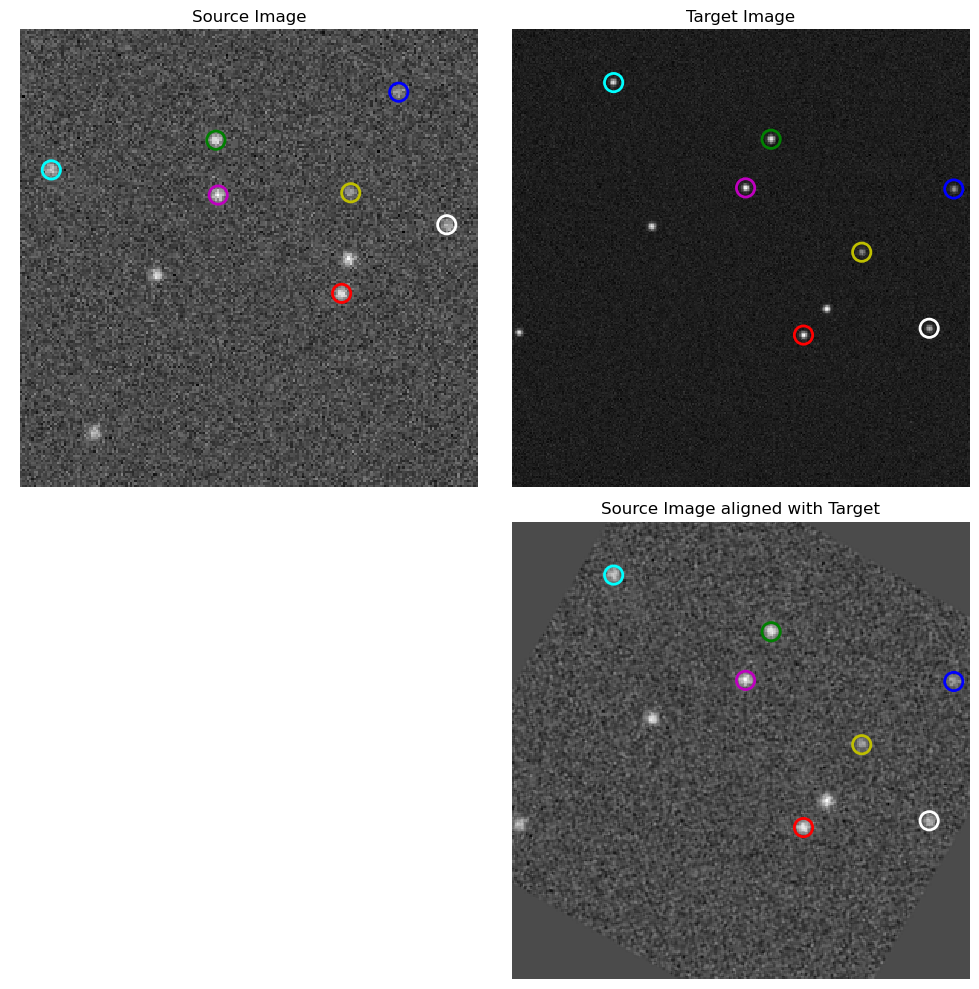

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

colors = ['r', 'g', 'b', 'y', 'cyan', 'w', 'm']

axes[0, 0].imshow(img_source, cmap='gray', interpolation='none', origin='lower')
axes[0, 0].axis('off')
axes[0, 0].set_title("Source Image")
for (xp, yp), c in zip(pos_img[:len(colors)], colors):
    circ = plt.Circle((xp, yp), 4, fill=False, edgecolor=c, linewidth=2)
    axes[0, 0].add_patch(circ)

axes[0, 1].imshow(img_target, cmap='gray', interpolation='none', origin='lower')
axes[0, 1].axis('off')
axes[0, 1].set_title("Target Image")
for (xp, yp), c in zip(pos_img_target[:len(colors)], colors):
    circ = plt.Circle((xp, yp), 4 * p.scale, fill=False, edgecolor=c, linewidth=2)
    axes[0, 1].add_patch(circ)

axes[1, 1].imshow(img_aligned, cmap='gray', interpolation='none', origin='lower')
axes[1, 1].axis('off')
axes[1, 1].set_title("Source Image aligned with Target")
for (xp, yp), c in zip(pos_img_target[:len(colors)], colors):
    circ = plt.Circle((xp, yp), 4 * p.scale, fill=False, edgecolor=c, linewidth=2)
    axes[1, 1].add_patch(circ)

axes[1, 0].axis('off')

plt.tight_layout()
plt.show()

### Finally one can apply the given transformation to the source image with same result as above

In [8]:
img_aligned2, footprint = aa.apply_transform(p, img_source, img_target)

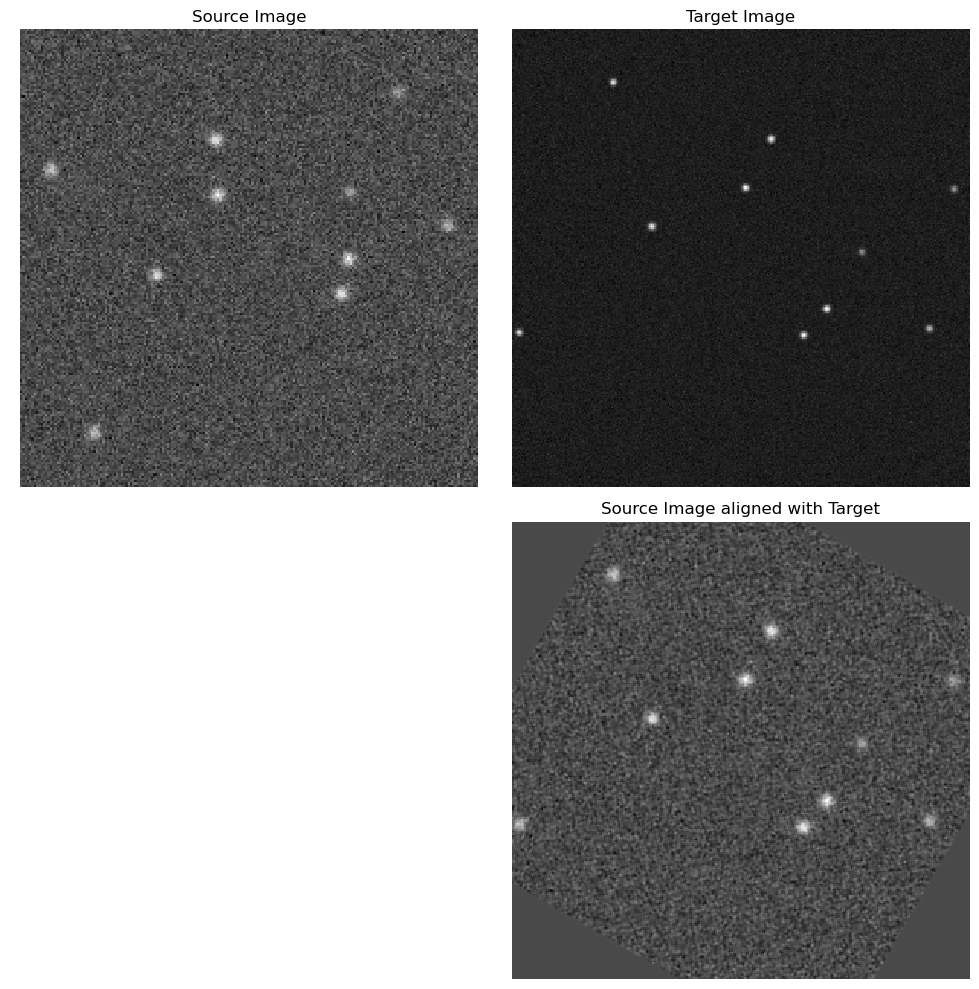

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(img_source, cmap='gray', interpolation='none', origin='lower')
axes[0, 0].axis('off')
axes[0, 0].set_title("Source Image")

axes[0, 1].imshow(img_target, cmap='gray', interpolation='none', origin='lower')
axes[0, 1].axis('off')
axes[0, 1].set_title("Target Image")

axes[1, 1].imshow(img_aligned2, cmap='gray', interpolation='none', origin='lower')
axes[1, 1].axis('off')
axes[1, 1].set_title("Source Image aligned with Target")

axes[1, 0].axis('off')

plt.tight_layout()
plt.show()
